# Notebook 5 - Pathway enrichment analysis of communities/modules of the chosen metabolomic features in composite outcome classification model. 

#### This notebook is a part of a project with the Center for Systems Biology at the University of Iceland. Here, the goal is to broaden the scope a bit by observing that behavior of the communities of the chosen features (for the classification of patient composite outcome). It allows for some more meaningful biological interpretation of the results. 

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Define functions:

In [107]:
def annotate_module_degree(expression_data,module_membership_data,df_modules,all_info_dat,df_mapped_metabolites,module_of_interest):
    
    '''
    This function summarises a module of interest with all the relevant data (features, mapped mets, adduts, rt, metabolite name)
    '''
    # m.z values:
    m_z = [float(x.split('_')[-1]) for x in expression_data.index.tolist()]
    
    # retention time:
    rt_dict = dict(zip(all_info_dat['mz_name'],all_info_dat['rt']))
    rt_vals = [rt_dict[x] for x in expression_data.index.tolist()]
    
    # Get p-values (0.049 when features are associated with module of interest)
    p_vals = np.ones(expression_data.shape[0])
    p_vals[df_modules[df_modules['Module']==int(module_of_interest)].index.tolist()] = 0.049
    
    # Get the membership values sorted:
    corr_vals = module_membership_data.loc[:,int(module_of_interest)]
    degree_vals = df_modules['Weighted.degree']

    outp_dataf = pd.DataFrame([expression_data.index.tolist(),m_z,rt_vals,corr_vals,degree_vals,p_vals]).T
    outp_dataf.columns = ['feature','m.z','r.t','corr.to.eigenvector','weighted.degree','p.value']
    
    # Now get matched "hits" from the metabolite dataframe:
    outp_dataf = pd.merge(outp_dataf, df_mapped_metabolites, on='feature', how='left')

    # Sort based on p-value:
    outp_dataf = outp_dataf.sort_values(by=['p.value','weighted.degree'],ascending=[True, False]).reset_index(drop = True)
    
    # Drop non-hitters:
    outp_dataf = outp_dataf.dropna(subset = ['metabolite_name'],axis = 0).reset_index(drop = True)
    
    # Drop the unknown_mz:
    outp_dataf = outp_dataf.drop(['unknown_mz'],axis = 1)
    return outp_dataf

def get_subset_pathways(annotated_module,pathbank_data,hmdb_or_kegg = 'HMDB'):
    
    '''
    This function creates a pathway dictionary where each pathway that is putatively annotated within a module
    maps to all its associated metabolite ids from pathbank data.
    '''
    
    dattt_subset = annotated_module[annotated_module['p.value'] < 0.05]
    if hmdb_or_kegg == 'HMDB':
        dat_subset = pathbank_data[pathbank_data['HMDB ID'].isin(dattt_subset['metabolite_id'].unique())].reset_index(drop = True)
        # Create a pathway dictionary:
        pathway_dict = {}

        # Use groupby to create a dictionary of pathway-metabolite associations
        pathway_dict = {group: data['HMDB ID'].tolist() for group, data in dat_subset.groupby('Pathway Name')}
    elif hmdb_or_kegg == 'KEGG':
        dat_subset = pathbank_data[pathbank_data['KEGG ID'].isin(dattt_subset['metabolite_id'].unique())].reset_index(drop = True)
        # Create a pathway dictionary:
        pathway_dict = {}

        # Use groupby to create a dictionary of pathway-metabolite associations
        pathway_dict = {group: data['KEGG ID'].tolist() for group, data in dat_subset.groupby('Pathway Name')}

    # Drop pathways that have less than 3 metabolite identifiers
    to_drop = []
    for key,val in pathway_dict.items():
        if len(val) < 1:
            to_drop.append(key)

    for pathway in to_drop:
        del pathway_dict[pathway]
    return pathway_dict


def pathway_enrichment_analysis(annotated_module,pathbank_data,hmdb_or_kegg = 'HMDB'):
    
    # START BY REMOVING SERINE FROM ANNOTATED MODULE:
    annotated_module = annotated_module[annotated_module['metabolite_id'] != 'HMDB0000187'].reset_index()
    
    # Assuming 'merged_df2' is your DataFrame with features and associated pathways
    if hmdb_or_kegg == 'HMDB':
        df_results2 = annotated_module.rename(columns = {'metabolite_id':'HMDB ID'})
        merged_df = pd.merge(df_results2, pathbank_data[['HMDB ID', 'Pathway Name']], on='HMDB ID', how='left')
        #print(merged_df)
    elif hmdb_or_kegg == 'KEGG':
        df_results2 = annotated_module.rename(columns = {'metabolite_id':'KEGG ID'})
        merged_df = pd.merge(df_results2, pathbank_data[['KEGG ID', 'Pathway Name']], on='KEGG ID', how='left')
    
    merged_df2 = merged_df.groupby('feature',sort = False)['Pathway Name'].apply(lambda x: [item for item in x if pd.notna(item)]).reset_index(name='pathways')
    df = merged_df2.copy()
    
    # List of pathways for analysis (Only do the ones that map to the hits of interest):
    pat_dict = get_subset_pathways(annotated_module,pathbank_data,hmdb_or_kegg = hmdb_or_kegg)
    #print(pat_dict)
    #print(len(pat_dict))
    if not pat_dict:
        print('Pathway dictionary is empty - no analysis is possible')
        results_df = pd.DataFrame()
        
    else:
        print('Annotating', len(pat_dict),'pathways...')
        pathways_to_test = list(pat_dict.keys())

        # DataFrame to store results
        results_list = []

        # Number of permutations for testing
        num_permutations = 1000

        # Specify the subset of features for analysis
        selected_features = list(np.unique(annotated_module[annotated_module['p.value'] < 0.05]['feature'].values))
        all_features = list(np.unique(annotated_module['feature'].values))

        for selected_pathway in pathways_to_test:

            # Observed count of selected pathway in the subset of features
            observed_count = np.sum(df[df['feature'].isin(selected_features)].apply(lambda x: selected_pathway in x['pathways'], axis=1))
            total_count_in_df = np.sum(df[df['feature'].isin(all_features)].apply(lambda x: selected_pathway in x['pathways'], axis=1))

            # Perform permutation testing
            permutation_counts = []
            for _ in range(num_permutations):
                # Shuffle the labels of the entire dataset
                shuffled_labels = np.random.permutation(df.index)
                #print(_)

                # Count the occurrences of the selected pathway in the shuffled labels
                shuffled_count = sum(df.loc[shuffled_labels[:len(selected_features)]].apply(lambda x: selected_pathway in x['pathways'], axis=1))
                permutation_counts.append(shuffled_count)

            # Calculate p-value based on permutation results
            p_value = (np.sum(np.array(permutation_counts) >= observed_count) + 1) / (num_permutations + 1)
            
            # Append results to the list
            results_list.append({
                'pathway': selected_pathway,
                'observed_count': observed_count,
                'observed_ratio':observed_count/total_count_in_df,
                'permutation_p.value': p_value,
            })

        # Convert the list to a DataFrame
        results_df = pd.DataFrame(results_list)
        results_df = results_df.sort_values(by = ['permutation_p.value'],ascending = [True]).reset_index(drop = True)
    return results_df
    
def create_accumulated_dict(series1,series2):
    out_dict = {}
    for indexx,element in enumerate(series1):
        if element not in out_dict:
            out_dict[element] = [series2[indexx]]
        else:
            out_dict[element].append(series2[indexx])
    return out_dict

def plot_selected_features(expression_data,selected_features,all_info_dat,df_mapped_metabolites,clinical_data):
    sns.reset_orig()
    colors = ["lightgrey", "dimgrey"]
    sns.set_palette(sns.color_palette(colors))
    sns.set_context("paper")
    #sns.set_style('whitegrid')
    '''
    A function that takes the "annotated_module" and plots the annotated features from the module and plots them according to the 
    "grouping_column" (e.g. clin_orig['Composite'])
    
    '''
    
     # m.z values:
    m_z = [float(x.split('_')[-1]) for x in expression_data.index.tolist()]
    
    # retention time:
    rt_dict = dict(zip(all_info_dat['mz_name'],all_info_dat['rt']))
    rt_vals = [rt_dict[x] for x in expression_data.index.tolist()]

    outp_dataf = pd.DataFrame([expression_data.index.tolist(),m_z,rt_vals]).T
    outp_dataf.columns = ['feature','m.z','r.t']
    
    # Now get matched "hits" from the metabolite dataframe:
    outp_dataf = pd.merge(outp_dataf, df_mapped_metabolites, on='feature', how='left')
    # Drop non-hitters:
    outp_dataf = outp_dataf.dropna(subset = ['metabolite_name'],axis = 0).reset_index(drop = True)
    
    # Drop the unknown_mz:
    outp_dataf = outp_dataf.drop(['unknown_mz'],axis = 1)
    
    
    outp_dataf = outp_dataf[outp_dataf['feature'].isin(selected_features)].reset_index(drop = True)
    feature_long_df = pd.concat([clinical_data['Composite'],expression_data[expression_data.T.columns.isin(outp_dataf['feature'].tolist())].T],axis = 1)
    
    dict_names = create_accumulated_dict(outp_dataf['feature'],outp_dataf['metabolite_name'])
    feature_long_df.rename(columns=lambda x: ', '.join(dict_names[x]) if x in dict_names else x, inplace=True)

    # ADD AN IF STATEMENT IF THERE ARE ANY DUPLICATES IN DF:
    
    # create unique identifier for each repeated column
    identifier = feature_long_df.columns.to_series().groupby(level=0).transform('cumcount')
    identifier+=1

    # rename columns with the new identifiers
    new_cols = feature_long_df.columns.astype('string') + '_' + identifier.astype('string')
    new_cols = [item[:-len('_1')] if item.endswith('_1') else item for item in new_cols]
    feature_long_df.columns = new_cols
    #feature_long_df.rename(columns = {'Composite_1':'Composite'},inplace=True)
    
    feature_long_df = feature_long_df.melt(id_vars=['Composite']).reset_index(drop = True)
    #print(feature_long_df)
    
    # Function to split labels at the nearest comma
    def split_labels(label):
        commas = [i for i, char in enumerate(label) if char == ',']
        if commas:
            middle_comma = commas[len(commas) // 2]  # Find the middle comma
            return label[:middle_comma] + '\n' + label[middle_comma+1:]
        else:
            return label

    feature_long_df['variable'] = feature_long_df['variable'].apply(split_labels)

    
    if not plt.get_fignums():
        plt.figure(figsize = (5,10))
    #plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    figg = sns.boxplot(data=feature_long_df, x="value", y="variable",
              hue="Composite", dodge=True, orient = 'h')
    plt.ylabel('', fontsize=16)
    plt.xlabel('Standardized Intensity', fontsize=12)
    #plt.savefig('Between_groups_main_features_JAN2024.svg',format='svg', bbox_inches='tight')
    plt.show()

## Load all data:

In [15]:
correlation_df = pd.read_csv('correlation_df_JAN2024.csv',index_col = 0)
correlation_df.columns = correlation_df.columns.astype(int)
eigendf = pd.read_csv('eigendf_trimmed_JAN2024.csv',index_col=0).reset_index(drop = True)
df_modules = pd.read_csv('df_modules_JAN2024.csv',index_col=0).reset_index(drop = True)
expression_data = pd.read_csv('All_data_normalised_21DEC2023.csv',index_col=0).T
all_info = pd.read_csv('xcms_output.csv',index_col=0).reset_index(drop = True)
feature_df = pd.read_csv('feature_df_JAN2024.csv',index_col = 0)
mz_to_mets = pd.read_csv('mz_to_mets_JAN2024.csv',index_col = 0)
clin_orig = pd.read_csv('Clinical_data_covid_study_2023.csv')
pathbank_dat = pd.read_csv('PathBank_data_JAN2024.csv',index_col = 0)

# Load the list back from the file
with open('Chosen_features_from_modeling.pkl', 'rb') as file:
    chosen_features = pickle.load(file)

with open('module_to_feature_dictionary.pkl', 'rb') as pickle_file:
    mod_dict = pickle.load(pickle_file)

## Pathway enrichment analysis:
#### Now to visualise the community of interest, and perform a pathway enrichment analysis on it.

#### What communities/modules do the most important features belong to?

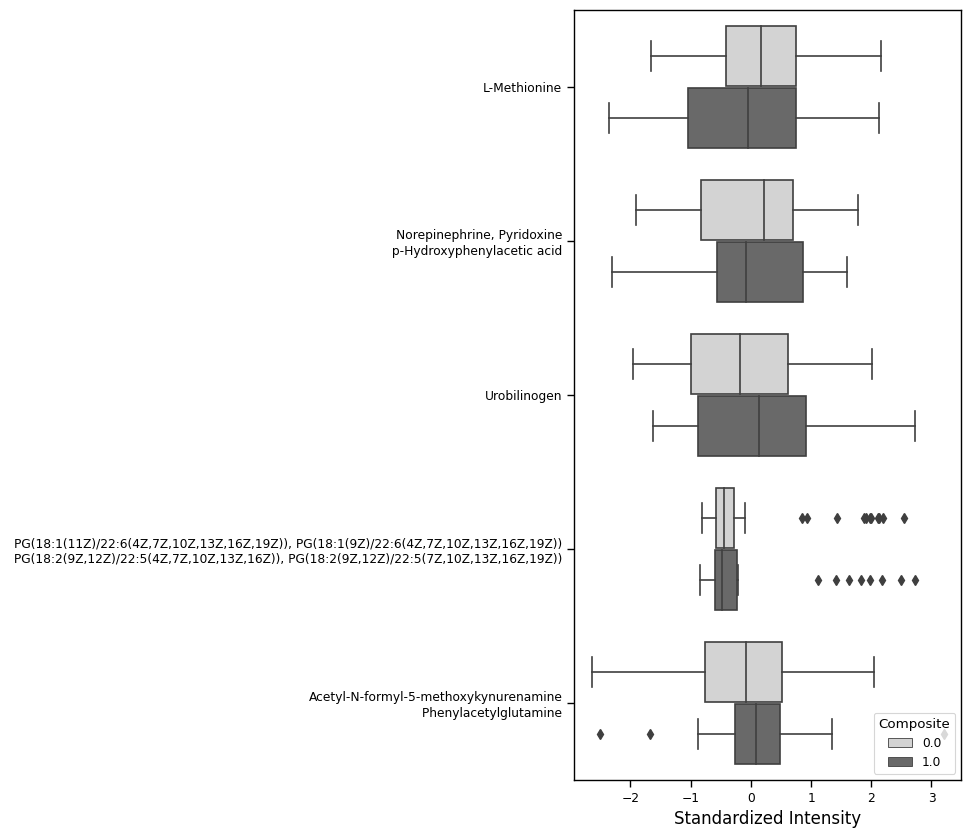

In [109]:
plot_selected_features(expression_data,chosen_features,all_info,mz_to_mets,clin_orig)

In [8]:
for ele in chosen_features:
    print([(ele+' belongs to Community no. ' + str(key)) for key,value in mod_dict.items() if value in ele][0])

pos_mz_152.0705369 belongs to Community no. 68
pos_mz_591.3174449 belongs to Community no. 72
pos_mz_843.5188545 belongs to Community no. 48
neg_mz_148.0425231 belongs to Community no. 8
bas_mz_263.1019867 belongs to Community no. 63


## Check the main features within each of the main communities:

In [84]:
module_of_interest = 63
annotated_module = annotate_module_degree(expression_data,correlation_df,df_modules,all_info,mz_to_mets,module_of_interest)
annotated_module[annotated_module['p.value'] < 0.05] # p-value < 0.05 represents all features that belong to this community

,feature,m.z,r.t,corr.to.eigenvector,weighted.degree,p.value,metabolite_id,adduct,ionization,mass_diff,metabolite_name
0,bas_mz_263.1019867,263.101987,357.406989,0.758783,0.453749,0.049,HMDB0004259,M - H,negative,4.620444,Acetyl-N-formyl-5-methoxykynurenamine
1,bas_mz_263.1019867,263.101987,357.406989,0.758783,0.453749,0.049,HMDB0006344,M - H,negative,4.620444,Phenylacetylglutamine
2,bas_mz_264.1053805,264.105381,357.558496,0.742628,0.443934,0.049,HMDB0000235,M - H,negative,3.295298,Thiamine
3,bas_mz_264.1053805,264.105381,357.558496,0.742628,0.443934,0.049,HMDB0004259,M(C13) - H,negative,4.473536,Acetyl-N-formyl-5-methoxykynurenamine
4,bas_mz_264.1053805,264.105381,357.558496,0.742628,0.443934,0.049,HMDB0006344,M(C13) - H,negative,4.473536,Phenylacetylglutamine
...,...,...,...,...,...,...,...,...,...,...,...
61,pos_mz_287.1000082,287.100008,151.331,0.390104,0.23514,0.049,HMDB0004259,M + Na,positive,3.024524,Acetyl-N-formyl-5-methoxykynurenamine
62,pos_mz_287.1000082,287.100008,151.331,0.390104,0.23514,0.049,HMDB0006344,M + Na,positive,3.024524,Phenylacetylglutamine
63,pos_mz_287.1000082,287.100008,151.331,0.390104,0.23514,0.049,HMDB0000195,M + H2O + H,positive,3.501504,Inosine
64,neg_mz_195.0507282,195.050728,173.898,0.359718,0.219365,0.049,HMDB0000150,M + H2O - H,negative,1.629608,Gluconolactone


## Perform pathway annotation using the DataFrame generated in the *"Annotation_procedure"* notebook:

In [85]:
pathway_enrichment_analysis(annotated_module,pathbank_dat,hmdb_or_kegg = 'HMDB')

Annotating 50 pathways...


,pathway,observed_count,observed_ratio,permutation_p.value
0,Tryptophan Metabolism,11,0.211538,0.001998
1,Phenylacetate Metabolism,7,0.291667,0.001998
2,Pentose Phosphate Pathway,3,0.428571,0.012987
3,Pyrimidine Metabolism,7,0.194444,0.013986
4,Warburg Effect,7,0.170732,0.025974
5,Glutathione Metabolism,3,0.250000,0.050949
6,Amino Sugar Metabolism,5,0.166667,0.068931
7,Glucose-Alanine Cycle,4,0.173913,0.090909
8,Thiamine Metabolism,2,0.250000,0.097902
9,Transfer of Acetyl Groups into Mitochondria,4,0.160000,0.106893
